General imports and libraries


In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# Markov decision process


## Creating the problem graph

<IPython.core.display.Javascript object>


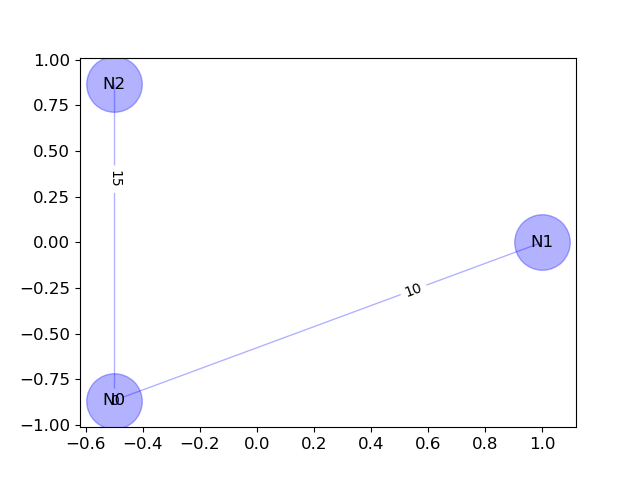

In [19]:
import networkx as nx
from graphs.utils import *
     
nodes = ["N0", "N1", "N2"]    
edges = [("N0","N0"), ("N0","N1"), ("N0", "N2")]
edge_weights = [0, 10,15] #ordered according to the edges list
node_weights = [1, 0.5,0.25] #ordered according to the node list

max_truck_capacities = [15,30]
max_tank_capacities = [np.inf, 100, 200] # == max_node_weights

G = create_graph(nodes, edges, edge_weights, node_weights, max_tank_capacities)

draw_graph(G, edges, edge_weights)


In [16]:
def print_node_weights(G):
    for node in G.nodes():
        print(node, G.node[node]) 
        
print_node_weights(G)        

N1 {'weight': 0.5, 'current_capacity': 50.0, 'max_capacity': 100}
N2 {'weight': 0.25, 'current_capacity': 50.0, 'max_capacity': 200}
N0 {'weight': 1, 'current_capacity': inf, 'max_capacity': inf}


In [17]:
# Lets update node N1 assuming it is now at the 75% of its capacity:
G.node["N1"]["weight"] = 0.75
print_node_weights(G)

N1 {'weight': 0.75, 'current_capacity': 50.0, 'max_capacity': 100}
N2 {'weight': 0.25, 'current_capacity': 50.0, 'max_capacity': 200}
N0 {'weight': 1, 'current_capacity': inf, 'max_capacity': inf}


In [18]:
G.edges[("N0","N0")]

{'weight': 0}

### Adjacency, incidence matrix of the graph, neighbours

In [6]:
nx.incidence_matrix(G).todense()

matrix([[1., 0., 0.],
        [0., 1., 0.],
        [1., 1., 0.]])

In [7]:
nx.incidence_matrix(G)

<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Column format>

In [8]:
print(G["N0"])

{'N1': {'weight': 10}, 'N2': {'weight': 15}, 'N0': {'weight': 0}}


In [9]:
my_dict = G["N0"]
for key in my_dict:
    print(key, my_dict[key]["weight"])

N1 10
N2 15
N0 0


## Creating the class of states and actions

In [161]:
import itertools

class Environment():
    pass


class State():
    def __init__(self, graph, truck_positions, truck_loads, tank_levels):
        self.p = truck_positions
        self.l = truck_loads
        self.c = tank_levels
        self.tpl = (self.p, self.l, self.c)
        
        self.n = len(self.c)
        self.k = len(self.p)
        
        self.G = graph
        
    def actions(self, tank_transfer_percentages: list):
        all_truck_actions_list = []
        
        for truck in range(self.k):
            current_truck_actions = []
            current_destinations = []
            
            current_truck_load = (self.l[truck]*max_truck_capacities[truck])
            destination_deliveries = np.array(tank_transfer_percentages) #.astype(list)
            #print(current_truck_load)
            #print(destination_deliveries)

            for destination in self.G[self.p[truck]]:
                
                #current_destinations.append(destination)
                
                destination_max_capacity = self.G.node[destination]["max_capacity"]
                
                max_delivery = max(
                    current_truck_load/destination_max_capacity,
                    (destination_max_capacity-current_truck_load)/destination_max_capacity
                )
                
                possible_truck_deliveries = destination_deliveries * current_truck_load
               # print(destination_deliveries, current_truck_load, possible_truck_deliveries)
                valid_truck_deliveries = possible_truck_deliveries[ 
                                    possible_truck_deliveries <= max_delivery * current_truck_load 
                                       ]
                current_destination_deliveries = valid_truck_deliveries.astype(list)
                #print(destination_deliveries)
                
                lists = [destination, current_destination_deliveries]
                print(lists)
                current_truck_actions.append([a for a in itertools.product(*lists) ])
            
            all_truck_actions_list.append(current_truck_actions)
                #print(lists[0], lists[1])
                
        return all_truck_actions_list
    

In [162]:

s0 = State(G, ("N0", "N0"), ( 0.5, 1 ) , (1, 0.5, 0.5))
print(s0.tpl[1][1])
print(s0.tpl)
print(s0.n, s0.k)

1
(('N0', 'N0'), (0.5, 1), (1, 0.5, 0.5))
3 2


In [163]:
lists = [
    G.nodes,
    (2*np.array([0.25,0.5,1])).astype(list)
]

product = itertools.product(*lists)
for element in product:
    print(element)
# Go from current node to node (first component) and empty the (second component) % of the truck load.

('N1', 0.5)
('N1', 1.0)
('N1', 2.0)
('N2', 0.5)
('N2', 1.0)
('N2', 2.0)
('N0', 0.5)
('N0', 1.0)
('N0', 2.0)


In [164]:
tank_transfer_percentages = [0.5,1]
truck_actions = s0.actions(tank_transfer_percentages)

truck = 0
actions0 = truck_actions[truck]
#print(actions0)
for actions in actions0:
    #for action in actions:
        print(actions)
    #pass#

['N1', array([3.75], dtype=object)]
['N2', array([3.75], dtype=object)]
['N0', array([], dtype=object)]
['N1', array([15.0], dtype=object)]
['N2', array([15.0], dtype=object)]
['N0', array([], dtype=object)]
[('N', 3.75), ('1', 3.75)]
[('N', 3.75), ('2', 3.75)]
[]


In [13]:


    

class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
        
    def reward_function(self, action):
        pass
        
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        
        return self.state, reward


In [14]:
G.edges()[0]

TypeError: 'int' object is not iterable